In [ ]:
!pip install -r requirements.txt

In [30]:
import langgraph
from langgraph.graph import StateGraph
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.document_loaders import TextLoader
import json
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from groq import Groq
import os
from typing import Dict, Optional, Any
from pydantic import BaseModel, ConfigDict
from reportlab.lib.pagesizes import LETTER
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader
from reportlab.lib import colors
from reportlab.platypus import Paragraph, SimpleDocTemplate, Spacer, Image as PlatypusImage
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_JUSTIFY, TA_CENTER
import base64
from io import BytesIO
import torch
import numpy as np
from PIL import Image
from diffusers import DiffusionPipeline

In [ ]:
with open(r"RAGData.json", "r", encoding="utf-8") as f:
    dataset = json.load(f)

docs = [{"text": item["content"], "metadata": {"title": item["title"], "type": item["type"]}} for item in dataset]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = text_splitter.create_documents(
    [doc["text"] for doc in docs], metadatas=[doc["metadata"] for doc in docs]
)


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


vectorstore = Chroma.from_documents(split_docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

print("✅ Dataset stored in ChromaDB successfully!")


✅ Dataset stored in ChromaDB successfully!


In [ ]:
class StoryState(BaseModel):
    """StoryState that supports both attribute and dictionary-style access."""
    prompt: Optional[str] = None
    story_context: Optional[str] = None
    rag_output: Optional[str] = None
    story: Optional[str] = None
    style: Optional[str] = None
    images: Optional[str] = None
    audio: Optional[str] = None
    image_prompt: Optional[str] = None
    validation_results: Optional[Dict[str, Any]] = None
    image_validation: Optional[list] = None


    model_config = ConfigDict(arbitrary_types_allowed=True)

    # Add dictionary-style access methods
    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, value):
        setattr(self, key, value)

    def __contains__(self, key):
        return hasattr(self, key)

    def get(self, key, default=None):
        return getattr(self, key, default)


# Initialize StateGraph with schema
workflow = StateGraph(state_schema=StoryState)

def retrieve_by_type(query, item_type, k=3):
    """Retrieve top-k relevant documents filtered by type."""
    retrieved_docs = retriever.get_relevant_documents(query)  # Retrieve all relevant docs
    filtered_docs = [doc for doc in retrieved_docs if doc.metadata["type"] == item_type]
    return filtered_docs[:k]  # Return top-k results

def retrieve_story_context(state: StoryState):
    query = state.prompt + "who is the character? where is the location? what is the object?"

    characters = retrieve_by_type(query, "Character", k=3)
    world_elements = retrieve_by_type(query, "Location", k=3)
    objects = retrieve_by_type(query, "Object", k=3)

    character_context = "\n".join(f"{doc.metadata['title']}: {doc.page_content}" for doc in characters)
    world_element_context = "\n".join(f"{doc.metadata['title']}: {doc.page_content}" for doc in world_elements)
    object_context = "\n".join(f"{doc.metadata['title']}: {doc.page_content}" for doc in objects)


    rag_output = f"Characters:\n{character_context}\n\n World Elements:\n{world_element_context}\n\n Objects:\n{object_context}"

    story_context = f"Story Context: {state.prompt}\n\n " + rag_output

    return {
        "story_context": story_context,
        "rag_output": rag_output
    }

workflow.add_node("retrieve_story_context", retrieve_story_context)


In [34]:
def generate_story(state: Dict):
    client = Groq()
    chat_completion = client.chat.completions.create(

     messages=[

        {
            "role": "system",
            "content":
                """
                    You are a creative author of many books. Your task is to generate a short story (700-800 words) based on the given context.

                    The user input contains:
                    1. 'Story Context' (Setting & Atmosphere)
                    2. 'Character' (Protagonist & Traits)
                    3. 'Location' (Primary Setting)
                    4. 'Item' (Key Object with Significance)

                    If any of these elements are missing from the user input, fill them in appropriately while maintaining a consistent theme and tone.

                    Ensure the story:
                    1. Has a clear beginning, middle, and end with a satisfying resolution.
                    2. Follows a structured narrative arc:
                        - Introduction: Establishes the setting, character, and mood.
                        - Conflict: Introduces the central challenge or mystery.
                        - Rising Action: Develops tension and explores character motivations.
                        - Climax: The most intense moment, revealing key discoveries or actions.
                        - Resolution: A satisfying conclusion that ties up loose ends.
                    3. Uses vivid descriptions to bring locations and characters to life.
                    4. Integrates the given item meaningfully in the plot.
                    5. Adds supporting characters where necessary to enhance the narrative, provide depth, or drive the plot forward.
                    6. Ensures logical coherence between events.

                    Make the story immersive, engaging, and emotionally compelling.

                    FIRST LINE MUST BE THE TITLE OF THE STORY
                """
        },
        {
            "role": "user",
            "content": state["story_context"],
        }
    ],

    model="llama-3.3-70b-versatile",


    temperature=0.7,


    max_completion_tokens=3000,


    top_p=1,


    stop=None,

    stream=False,
)

    story = chat_completion.choices[0].message.content
    print("debug: story:", story)
    return {"story": story}

workflow.add_node("generate_story", generate_story)

In [ ]:
def validate_story(state: StoryState):
    """Validates the generated story for structure, consistency, and quality."""
    client = Groq()

    # Combine prompt and story for validation context
    validation_input = {
        "prompt": state.prompt,
        "story_context": state.story_context,
        "story": state.story
    }

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
                You are a critical story editor tasked with validating stories against specific criteria.
                Analyze the story and provide an assessment with the following validation criteria:

                1. Story Structure (Pass/Fail):
                   - Does the story have a clear beginning, middle, and end?
                   - Is there a complete narrative arc with conflict and resolution?

                2. Element Consistency (Pass/Fail):
                   - Are characters from the context used appropriately in the story?
                   - Are locations/settings from the context incorporated effectively?
                   - Is the key object meaningfully integrated into the plot?

                3. Length Assessment (Pass/Fail):
                   - Is the story within the target length (700-800 words)?
                   - Word count estimate:

                4. Thematic Consistency (Pass/Fail):
                   - Does the story maintain appropriate tone and genre?
                   - Do plot elements align with the original prompt?

                5. Quality Assessment (Pass/Fail):
                   - Does the story use descriptive language effectively?
                   - Overall engagement and readability:

                6. Recommendations for Improvement:
                   - Specific suggestions to address any failing areas:

                7. Final Verdict (Pass/Fail):
                   - Overall assessment:

                Return your assessment as a JSON object with these fields.
                """
            },
            {
                "role": "user",
                "content": f"""
                Original Prompt: {validation_input['prompt']}

                Story Context: {validation_input['story_context']}

                Generated Story: {validation_input['story']}

                Please validate this story according to the criteria.
                """
            }
        ],
        model="llama-3.3-70b-versatile",
        temperature=0.1,
        max_completion_tokens=2000,
        response_format={"type": "json_object"}
    )

    validation_results = json.loads(chat_completion.choices[0].message.content)

    return {"validation_results": validation_results}

workflow.add_node("validate_story", validate_story)






def should_regenerate(state: StoryState):
    """Determines if the story needs to be regenerated based on validation results."""
    validation = state.validation_results

    print(f"DEBUG - Content of validation_results: {validation}")
    print('\n\n')

    try:
        # Check if the final verdict is a fail
        if validation.get("Final Verdict") == "Fail":
            print("Regenerating story due to validation failure.")

            # Create updated story context with validation feedback
            recommendations = validation.get("Recommendations for Improvement", [])
            recommendations_text = "\n".join([f"- {rec}" for rec in recommendations]) if recommendations else "No specific recommendations provided."

            # Update the state with enhanced context
            enhanced_context = (
                f"Story Context: {state.prompt}\n\n"
                f"{state.rag_output}\n\n"
                f"IMPORTANT - Previous story attempt failed validation. Please address these issues:\n"
                f"{recommendations_text}\n\n"
                f"Failed aspects: "
            )

            # Add specific failed criteria
            for key, value in validation.items():
                if key not in ["Recommendations for Improvement", "Final Verdict", "Word count estimate"] and value == "Fail":
                    enhanced_context += f"{key}, "

            if enhanced_context.endswith(", "):
                enhanced_context = enhanced_context[:-2]

            state.story_context = enhanced_context

            return "regenerate_story"
        else:
            print("Story is valid, proceeding with image_prompt generation.")
            return "generate_image_prompt"
    except (TypeError, AttributeError):
        print("Warning: Validation results are malformed, proceeding with image generation")
        return "generate_image_prompt"

In [ ]:
def generate_image_prompt(state: StoryState):
    client = Groq()

    # Get rag_output safely
    rag_output = state.rag_output or ""

    chat_completion = client.chat.completions.create(
        # Required parameters
        messages=[
            {
                "role": "system",
                "content": """
                You are an expert in visual storytelling and AI image generation. Your job is to turn story scenes into short, optimized prompts for models like Stable Diffusion or DALL·E.
                You should also keep the relevant, detailed story related to the scene under "scene_text"

                For each scene:
                - Return a dictionary with three keys: "scene" (scene number), "scene_text" (original scene description), and "prompt" (concise image generation prompt).
                - Limit "prompt" to 50 words max.
                - "scene_text" can have any number of words
                - Always include in the prompt: main character (with age/appearance/clothing), key object, and location.
                - Describe the setting: environment, colors, atmosphere.
                - Highlight any important visual elements.
                - Define composition and style (e.g., noir, steampunk, wide shot, close-up, low angle).

                Important:
                - Do NOT use the word "cinematic", "close", "realistic" in any prompt.
                - ALWAYS use the word "wide-shot" in all prompt.
                - Use the same main genre (e.g., fiction or sci-fi etc) across all scenes.
                - Always mention the same character details (e.g., "Detective Jack Blackwood, 30, rugged, sharp green eyes") in every prompt.
                - Keep the same main visual style (e.g., animated or vintage etc) throughout all "prompt".
                - Maintain visual and narrative coherence in every prompt.

                Use this story context: {rag_output} to extract scene details and ensure consistency.

                Example:
                [
                    {{
                        "scene": "1",
                        "scene_text": "In the heart of Nova City, where the neon lights of holographic advertisements cast a kaleidoscope of colors across the rain-slicked streets, Detective Jack Blackwood stood out as a relic of the past. His rugged, stubble-ridden face and sharp green eyes seemed to hold a world of wisdom...",
                        "prompt": "Detective Jack Blackwood, rugged, sharp green eyes, stands in neon-lit, rain-slicked Nova City street. Holographic ads glow around him. Night setting, cinematic wide shot. Genre: mystery. Style: realistic, noir-inspired, vibrant lighting, moody atmosphere, reflective surfaces, urban sci-fi backdrop."
                    }},
                    {{
                        "scene": "2",
                        "scene_text": "Yet, on this particular evening, Jack's intuition had led him to a small, mysterious shop tucked away in a forgotten alley... 'I think you'll find this item of particular interest. It's a Historian's Monocle, said to reveal the secrets of the past.'",
                        "prompt": "Detective Jack Blackwood, rugged, sharp green eyes, holds ornate gold-framed monocle in small antique box, skeptical yet curious gaze. Inside dimly lit vintage shop. Cinematic close-up. Genre: mystery. Style: realistic, dramatic lighting, high contrast shadows, film noir mood, aged textures."
                    }},
                    {{
                        "scene": "3",
                        "scene_text": "He put on the monocle, and suddenly, the world around him transformed. Ghostly images of people and events from bygone eras began to materialize...",
                        "prompt": "Detective Jack Blackwood, wearing gold-framed Historian's Monocle, sees ghostly past figures in neon-lit street. Rain reflects colored lights. Cinematic frame. Genre: mystery. Style: realistic, atmospheric, ghostly overlays, dramatic contrast, rain-soaked urban backdrop."
                    }},
                    {{
                        "scene": "4",
                        "scene_text": "As he explored the city with the Historian's Monocle, Jack became aware of a peculiar connection between Nova City and a place called the Clockwork Citadel...",
                        "prompt": "Detective Jack Blackwood, wearing monocle, gazes toward mechanical skyline of Clockwork Citadel—brass, copper, steel glimmering. Mechanical birds fly above. Wide cinematic shot. Genre: mystery. Style: realistic, steampunk, metallic textures, warm tones, industrial atmosphere."
                    }}
                ]

                Return a list of dictionaries only.
                """.format(rag_output=rag_output) 
            },
            {
                "role": "user",
                "content": state.story or ""
            }
        ],
        model="llama-3.3-70b-versatile",
        temperature=0.05,
        max_completion_tokens=3000,
        top_p=1,
        stop=None,
        stream=False,
    )

    image_prompt = chat_completion.choices[0].message.content
    print(f"DEBUG - image_prompt: {image_prompt}")
    return {"image_prompt": image_prompt}


workflow.add_node("generate_image_prompt", generate_image_prompt)

In [ ]:
def generate_images(state: StoryState):


    image_prompt_str = state.image_prompt
    image_prompt_list = json.loads(image_prompt_str)
    prompts = [scene["prompt"] for scene in image_prompt_list]

    pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")
    pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

    generated_images = []  
    for idx, prompt in enumerate(prompts, start=1):
        image = pipe(prompt).images[0]
        image.save(f"scene_{idx}.png")  
        generated_images.append(image)


    return {"images": generated_images}
workflow.add_node("generate_images", generate_images)


In [ ]:
def validate_images(state: StoryState):
    """
    Validates each generated image by captioning it and comparing with the original prompt.
    If an image doesn't match its prompt, it will be regenerated with an LLM-enhanced prompt.
    """


    # Initialize Groq client
    client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

    # Parse image prompts
    image_prompt_str = state.image_prompt
    image_prompt_list = json.loads(image_prompt_str)
    prompts = [scene["prompt"] for scene in image_prompt_list]

    # Get the previously generated images
    images = state.images
    regenerated_images = images.copy() 
    regenerate_count = 0
    validation_results = []

    # Process each image
    for idx, (image, prompt) in enumerate(zip(images, prompts)):
        # Convert PIL Image to base64
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')

        # Get image caption using Groq
        try:
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": "Describe what you see in this image in detail."},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}",
                                },
                            },
                        ],
                    }
                ],
                model="meta-llama/llama-4-scout-17b-16e-instruct",
                temperature=0.1,
                max_completion_tokens=500
            )
            caption = chat_completion.choices[0].message.content

            # Compare caption with prompt
            comparison_result = client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": """
                        You are an image validator comparing an image caption with its intended prompt.
                        Determine if the caption adequately reflects the key elements in the prompt.
                        Focus on:
                        1. Main characters and their appearance
                        2. Setting/environment
                        3. Key objects
                        4. Overall atmosphere and style

                        Return a JSON with these fields:
                        {
                            "score": [number between 0-10],
                            "match": [true/false - true if score >= 6],
                            "missing_elements": [list of key elements from prompt missing in caption],
                            "recommendation": [brief recommendation if match is false]
                        }
                        """
                    },
                    {
                        "role": "user",
                        "content": f"""
                        Original prompt: "{prompt}"

                        Image caption: "{caption}"

                        Analyze how well the caption matches the prompt. Return only a JSON object.
                        """
                    }
                ],
                model="llama-3.3-70b-versatile",
                temperature=0.1,
                response_format={"type": "json_object"}
            )

            comparison = json.loads(comparison_result.choices[0].message.content)

            # Store validation result
            validation_results.append({
                "scene": idx + 1,
                "prompt": prompt,
                "caption": caption,
                "comparison": comparison
            })

            print(f"DEBUG - Validation result for scene {idx + 1}: {validation_results[-1]}")

            # Regenerate image if needed
            if not comparison["match"]:
                print(f"Scene {idx+1} failed validation. Regenerating...")

                # Have the LLM create an enhanced prompt that includes missing elements
                missing_elements = comparison["missing_elements"]
                
                enhanced_prompt_completion = client.chat.completions.create(
                    messages=[
                        {
                            "role": "system",
                            "content": """
                            You are an expert at creating image generation prompts.
                            Your task is to rewrite a given prompt to include specific missing elements
                            while maintaining approximately the same word count and preserving the
                            style, tone, and core elements of the original prompt.

                            Return ONLY the revised prompt text without any explanation or additional text.
                            """
                        },
                        {
                            "role": "user",
                            "content": f"""
                            Original prompt: "{prompt}"

                            Missing elements that need to be clearly included: {', '.join(missing_elements)}

                            Please rewrite the prompt to ensure these elements are clearly included
                            while maintaining approximately the same length and preserving the style and tone.
                            Do not add "NOTE:" or other meta-instructions in the prompt.
                            """
                        }
                    ],
                    model="llama-3.3-70b-versatile",
                    temperature=0.2,
                    max_completion_tokens=500
                )

                enhanced_prompt = enhanced_prompt_completion.choices[0].message.content.strip()
                print(f"Enhanced prompt: {enhanced_prompt}")

                # Regenerate the image with the enhanced prompt
                pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")
                pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")
                new_image = pipe(enhanced_prompt).images[0]

                # Save and update the image
                new_image.save(f"scene_{idx+1}_regenerated.png")
                regenerated_images[idx] = new_image
                regenerate_count += 1

                # Add the enhanced prompt to validation results
                validation_results[-1]["enhanced_prompt"] = enhanced_prompt

        except Exception as e:
            print(f"Error validating image {idx+1}: {str(e)}")
            validation_results.append({
                "scene": idx + 1,
                "error": str(e)
            })

    print(f"Image validation complete. {regenerate_count} images were regenerated.")

    return {
        "images": regenerated_images,
        "image_validation": validation_results
    }


workflow.add_node("validate_images", validate_images)

In [ ]:
def compilation_agent(state: StoryState, output_pdf_path="compiled_story.pdf"):
    """
    Creates a professionally formatted PDF with story text and images interleaved.
    Images are placed at appropriate points in the story based on scene text.
    """


    # Extract data
    story_text = state["story"]
    images = state["images"]

    # Parse image prompts to get scene text
    image_prompt_str = state["image_prompt"]
    scene_data = json.loads(image_prompt_str)

    # Create PDF document
    doc = SimpleDocTemplate(
        output_pdf_path,
        pagesize=LETTER,
        leftMargin=1*inch,
        rightMargin=1*inch,
        topMargin=1*inch,
        bottomMargin=1*inch
    )

    # Create styles
    styles = getSampleStyleSheet()
    styles.add(ParagraphStyle(
        name='StoryText',
        fontName='Times-Roman',
        fontSize=12,
        leading=14,
        alignment=TA_JUSTIFY,
        firstLineIndent=24
    ))

    styles.add(ParagraphStyle(
      name='CustomTitle',
      fontName='Helvetica-Bold',
      fontSize=18,
      leading=22,
      alignment=TA_CENTER,
      spaceAfter=12
    ))

    # Extract title from beginning of story (first line or sentences)
    title_text = story_text.strip().split('\n')[0]
    if len(title_text) > 100:  # If first line is too long, it's probably not a title
        title_text = "My Story"  # Default title

    # Build elements list
    elements = []

    # Add title
    elements.append(Paragraph(title_text, styles['Title']))
    elements.append(Spacer(1, 0.25*inch))

    # Map scenes to appropriate places in the story
    scene_positions = []

    # Process each scene to find its position in the story
    for scene in scene_data:
        scene_text = scene.get("scene_text", "").strip()
        if len(scene_text) > 20:
            search_text = scene_text[:min(100, len(scene_text))]
            pos = story_text.find(search_text)
            if pos >= 0:
                scene_positions.append((pos, scene.get("scene", ""), scene_text))


    scene_positions.sort()

    # Break up story text and insert images
    last_pos = 0
    for i, (pos, scene_num, scene_text) in enumerate(scene_positions):
        if i < len(images): 
            # Add text leading up to this scene
            text_chunk = story_text[last_pos:pos].strip()
            if text_chunk:
                elements.append(Paragraph(text_chunk, styles['StoryText']))
                elements.append(Spacer(1, 0.1*inch))

            # Convert PIL image to reportlab image
            img = images[i]
            img_width = 5 * inch  # Max width
            img_height = (img.height / img.width) * img_width

            # Scale Image
            if img_height > 7 * inch:
                img_height = 7 * inch
                img_width = (img.width / img.height) * img_height


            img_buffer = BytesIO()
            img.save(img_buffer, format='PNG')
            img_buffer.seek(0)

            # Add the image
            img_obj = PlatypusImage(img_buffer, width=img_width, height=img_height)
            elements.append(img_obj)
            elements.append(Spacer(1, 0.2*inch))

            last_pos = pos

    # Add remaining text
    if last_pos < len(story_text):
        remaining_text = story_text[last_pos:].strip()
        if remaining_text:
            elements.append(Paragraph(remaining_text, styles['StoryText']))


    doc.build(elements)

    print(f"\n✅ PDF saved to: {os.path.abspath(output_pdf_path)}")
    return {"pdf_path": output_pdf_path}

workflow.add_node("compilation_agent", compilation_agent)


In [ ]:
workflow.add_edge("retrieve_story_context", "generate_story")
workflow.add_edge("generate_story", "validate_story")

workflow.add_edge("generate_image_prompt","generate_images")

workflow.add_edge("generate_images", "validate_images")
workflow.add_edge("validate_images","compilation_agent")

workflow.add_conditional_edges(
    "validate_story",
    should_regenerate,
    {
        "regenerate_story": "generate_story",
        "generate_image_prompt": "generate_image_prompt"
    }
)



workflow.set_entry_point("retrieve_story_context")

compiled_workflow = workflow.compile()



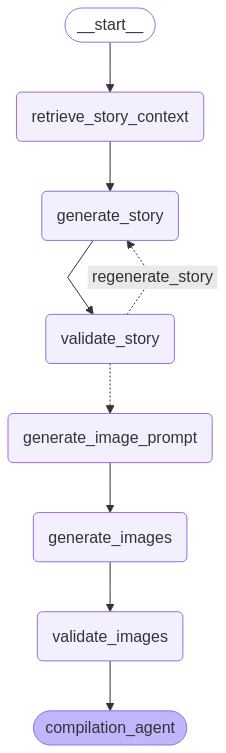

In [ ]:
from IPython.display import Image, display

try:
    display(Image(compiled_workflow.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Cannot print graph: {str(e)}")



In [ ]:
# Run the Workflow
GROQ_API_KEY = ""

def run_workflow(input_prompt):
    input_state = {"prompt": input_prompt}
    os.environ["GROQ_API_KEY"] = GROQ_API_KEY
    return compiled_workflow.invoke(input_state)

input_prompt = "There once was a young little girl in a magical forest. She came accross a map"

result = run_workflow(input_prompt)


debug: story: The Whispering Map of Wonders

In a mystical forest, where ancient trees whispered secrets to the wind, and creatures of magic roamed free, a young girl named Luna stumbled upon a mysterious parchment. The Whispering Map, as it came to be known, was an enchanted artifact that continuously redraws itself to reveal the immediate surroundings of its holder. With an insatiable curiosity, Luna unfolded the map, and her eyes widened as the parchment came to life, displaying hidden doors, recent footprints, and magical emanations through specialized symbols. The map's magic was palpable, and Luna felt an instant connection to it, as if it held the key to unlocking the secrets of the mystical forest.

As she wandered through the forest, the Whispering Map guided Luna, revealing hidden pathways and secret glades. The map's symbols danced across its surface, pointing out subtle changes in the environment, from the faint glow of luminescent mushrooms to the soft rustle of leaves ind

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG - Validation result for scene 1: {'scene': 1, 'prompt': 'Luna, 12, curious, brown hair, holds Whispering Map in mystical forest. Ancient trees, magical creatures. Wide-shot, fantasy, vibrant, moonlit, mystical atmosphere.', 'caption': "The image depicts a young girl standing in a forest, holding a map and gazing to her left. She has long brown hair and wears a red dress with a blue collar and sleeves.\n\n*   The girl is positioned on the right side of the image.\n    *   She has long brown hair.\n    *   She wears a red dress with a blue collar and sleeves.\n    *   She holds a white map in her hands.\n*   A large tree trunk is visible on the left side of the image.\n    *   The tree trunk is thick and brown.\n    *   A lantern hangs from a branch above the trunk.\n    *   The lantern is lit and emits a warm glow.\n*   The background features a forest with tall trees and grass.\n    *   The sky is blue and hazy.\n    *   The moon is full and shines brightly in the top-right corne

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG - Validation result for scene 5: {'scene': 5, 'prompt': 'Luna, 12, curious, brown hair, with badgers, approaches ancient tree with Whispering Map. Riddle on bark, badgers guide her. Wide-shot, fantasy, friendly, forest atmosphere.', 'caption': 'The image depicts a serene scene of two badgers resting in the shade of a large tree, with a person partially visible on the right side. The badgers are positioned in front of the tree\'s trunk, which is adorned with visible roots and branches. The badger on the left has its head turned towards the viewer, while the one on the right lies down, facing forward.\n\nIn the foreground, the grassy area features scattered flowers and leaves, adding to the natural ambiance. A watermark across the center of the image reads "©2017 Fiona Mcodbc Piepps" in white text.\n\nOn the right side of the image, a person is partially visible, wearing a blue shirt over a striped long-sleeved shirt. Their back is turned towards the viewer, and their head is not v

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG - Validation result for scene 6: {'scene': 6, 'prompt': 'Luna, 12, curious, brown hair, solves riddle with Whispering Map. Waterfall parts, revealing hidden path. Wide-shot, fantasy, triumphant, natural atmosphere.', 'caption': 'The image depicts a young girl standing in front of a waterfall, with her right hand raised to her shoulder and her left arm extended outward. She has long brown hair and wears a purple dress.\n\nIn the foreground, a wooden structure resembling a bridge or dock is visible, although it appears to be broken or damaged. The background features a lush green landscape with a waterfall cascading down a rocky cliffside. The overall atmosphere of the image suggests a serene and peaceful setting, with the girl seemingly connected to nature.', 'comparison': {'score': 7, 'match': True, 'missing_elements': ['age (12) and personality (curious) of the main character', 'Whispering Map', 'hidden path', 'triumphant atmosphere', 'fantasy style'], 'recommendation': "Include

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image validation complete. 3 images were regenerated.

✅ PDF saved to: /content/compiled_story.pdf


In [43]:
print(result.keys())

dict_keys(['prompt', 'story_context', 'rag_output', 'story', 'images', 'image_prompt', 'validation_results', 'image_validation'])


In [51]:
print(result["prompt"])

There once was a young little girl in a magical forest. She came accross a map


In [53]:
print(result["rag_output"])

Characters:
Character: Luna Silverheart: A willowy girl with long brown hair and large, luminous eyes that reflect moonlight. As wolf-speaker and forest guardian, she is solitary, intuitive, and more comfortable among animals than humans who fear her strange abilities.
Character: Imelda Cortez: A vibrant woman with silver-streaked black hair and expressive hands. Working as village storyteller, she is dramatic, wise, and keeps cultural traditions alive through tales that entertain children and contain hidden warnings for adults.

World Elements:
Location: Avalon: A mystical island veiled from mortal eyes by perpetual mist. Ancient apple orchards produce fruit that grants extended youth, and magical beings tend to injured legendary heroes who rest here until the world needs them again. The island slowly rotates through different planes of existence, making its location impossible to chart on any single map.
Location: Whispering Woods: A mystical forest filled with glowing mushrooms, anc

In [55]:
print(result["story_context"])

Story Context: There once was a young little girl in a magical forest. She came accross a map

 Characters:
Character: Luna Silverheart: A willowy girl with long brown hair and large, luminous eyes that reflect moonlight. As wolf-speaker and forest guardian, she is solitary, intuitive, and more comfortable among animals than humans who fear her strange abilities.
Character: Imelda Cortez: A vibrant woman with silver-streaked black hair and expressive hands. Working as village storyteller, she is dramatic, wise, and keeps cultural traditions alive through tales that entertain children and contain hidden warnings for adults.

World Elements:
Location: Avalon: A mystical island veiled from mortal eyes by perpetual mist. Ancient apple orchards produce fruit that grants extended youth, and magical beings tend to injured legendary heroes who rest here until the world needs them again. The island slowly rotates through different planes of existence, making its location impossible to chart on 

In [46]:
print(result["story"])

The Whispering Map of Wonders

In a mystical forest, where ancient trees whispered secrets to the wind, and creatures of magic roamed free, a young girl named Luna stumbled upon a mysterious parchment. The Whispering Map, as it came to be known, was an enchanted artifact that continuously redraws itself to reveal the immediate surroundings of its holder. With an insatiable curiosity, Luna unfolded the map, and her eyes widened as the parchment came to life, displaying hidden doors, recent footprints, and magical emanations through specialized symbols. The map's magic was palpable, and Luna felt an instant connection to it, as if it held the key to unlocking the secrets of the mystical forest.

As she wandered through the forest, the Whispering Map guided Luna, revealing hidden pathways and secret glades. The map's symbols danced across its surface, pointing out subtle changes in the environment, from the faint glow of luminescent mushrooms to the soft rustle of leaves indicating the pr

In [45]:
print(result["image_prompt"])

[
    {
        "scene": "1",
        "scene_text": "In a mystical forest, where ancient trees whispered secrets to the wind, and creatures of magic roamed free, a young girl named Luna stumbled upon a mysterious parchment. The Whispering Map, as it came to be known, was an enchanted artifact that continuously redraws itself to reveal the immediate surroundings of its holder.",
        "prompt": "Luna, 12, curious, brown hair, holds Whispering Map in mystical forest. Ancient trees, magical creatures. Wide-shot, fantasy, vibrant, moonlit, mystical atmosphere."
    },
    {
        "scene": "2",
        "scene_text": "As she wandered through the forest, the Whispering Map guided Luna, revealing hidden pathways and secret glades. The map's symbols danced across its surface, pointing out subtle changes in the environment, from the faint glow of luminescent mushrooms to the soft rustle of leaves indicating the presence of hidden creatures.",
        "prompt": "Luna, 12, curious, brown hair,

In [50]:
from pprint import pprint
pprint(result["validation_results"])

{'Element Consistency': 'Pass',
 'Final Verdict': 'Pass',
 'Length Assessment': 'Pass',
 'Quality Assessment': 'Pass',
 'Recommendations for Improvement': ['Consider adding more character '
                                     'development for Luna beyond her '
                                     'curiosity and connection to the map',
                                     'Introduce conflicts or challenges that '
                                     "test Luna's resolve and growth as a "
                                     'guardian of the forest',
                                     'Explore the world beyond the mystical '
                                     "forest to expand the story's scope and "
                                     'possibilities'],
 'Story Structure': 'Pass',
 'Thematic Consistency': 'Pass',
 'Word count estimate': 750}


In [ ]:
pprint(result["image_validation"])

[{'caption': 'The image depicts a young girl standing in a forest, holding a '
             'map and gazing to her left. She has long brown hair and wears a '
             'red dress with a blue collar and sleeves.\n'
             '\n'
             '*   The girl is positioned on the right side of the image.\n'
             '    *   She has long brown hair.\n'
             '    *   She wears a red dress with a blue collar and sleeves.\n'
             '    *   She holds a white map in her hands.\n'
             '*   A large tree trunk is visible on the left side of the '
             'image.\n'
             '    *   The tree trunk is thick and brown.\n'
             '    *   A lantern hangs from a branch above the trunk.\n'
             '    *   The lantern is lit and emits a warm glow.\n'
             '*   The background features a forest with tall trees and grass.\n'
             '    *   The sky is blue and hazy.\n'
             '    *   The moon is full and shines brightly in the top